In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import pickle
import matplotlib as plt

# Step 1: Generate synthetic data
np.random.seed(42)  # For reproducibility

# Generate features - 300 training samples, 100 features each
X = np.random.rand(400, 100)
# Generate target values - a linear combination of features plus some noise
coefficients = np.random.rand(100)
y = X @ coefficients + np.random.randn(400) * 0.1

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert to DataFrame for convenience
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)
y_train = pd.Series(y_train, name='target')
y_test = pd.Series(y_test, name='target')


In [39]:
train_features = pd.read_csv('data/train_features.csv')

# Extract pothole id from image_file column: "p1046.jpg" -> 1046
train_features['Pothole number'] = train_features['image_file'].str.extract(r'p(\d+)\.jpg').astype(int)
train_features.drop(columns='image_file', inplace=True)

# Get labels from labels.csv and add to potholes in train_features
labels = pd.read_csv('data/labels.csv')
train_features = train_features.merge(labels, how='left', on='Pothole number')

# Remove rows with missing labels
train_features.dropna(subset=['Bags used '], inplace=True)

# Convert hu moment 0, 1, 2, 3, 4, 5, 6 columns from string [2.01234] to float 2.01234
for i in range(7):
    train_features[f'hu_moment_{i}'] = train_features[f'hu_moment_{i}'].str.extract(r'\[(.*)\]').astype(float)

sup_features = pd.read_csv('data/sup_features.csv')

# Extract pothole id from image_file column: "p1046.jpg" -> 1046
sup_features['Pothole number'] = sup_features['image_file'].str.extract(r'p(\d+)\.jpg').astype(int)
sup_features.drop(columns='image_file', inplace=True)

# Get labels from labels.csv and add to potholes in train_features
labels = pd.read_csv('data/sup_labels.csv')
sup_features = sup_features.merge(labels, how='left', on='Pothole number')

# Remove rows with missing labels
sup_features.dropna(subset=['Bags used '], inplace=True)

# Convert hu moment 0, 1, 2, 3, 4, 5, 6 columns from string [2.01234] to float 2.01234
for i in range(7):
    sup_features[f'hu_moment_{i}'] = sup_features[f'hu_moment_{i}'].str.extract(r'\[(.*)\]').astype(float)

# Combine sup_features and train_features
train_features = pd.concat([train_features, sup_features])

val_features = pd.read_csv('data/val_features.csv')

# Extract pothole id from image_file column: "p1046.jpg" -> 1046
val_features['Pothole number'] = val_features['image_file'].str.extract(r'p(\d+)\.jpg').astype(int)
val_features.drop(columns='image_file', inplace=True)

# Get labels from labels.csv and add to potholes in train_features
labels = pd.read_csv('data/labels.csv')
val_features = val_features.merge(labels, how='left', on='Pothole number')

# Remove rows with missing labels
val_features.dropna(subset=['Bags used '], inplace=True)

# Convert hu moment 0, 1, 2, 3, 4, 5, 6 columns from string [2.01234] to float 2.01234
for i in range(7):
    val_features[f'hu_moment_{i}'] = val_features[f'hu_moment_{i}'].str.extract(r'\[(.*)\]').astype(float)

# X_train = train_features.drop(columns=['Pothole number', 'Bags used '])
# y_train = train_features['Bags used ']

# X_test = val_features.drop(columns=['Pothole number', 'Bags used '])
# y_test = val_features['Bags used ']

# # Put test data columns in same order as train data columns
# X_test = X_test[X_train.columns]

# combine train and val features
X = pd.concat([train_features, val_features])
y = X['Bags used ']
X.drop(columns=['Pothole number', 'Bags used '], inplace=True)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [40]:
# Impute missing data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# XGBoost


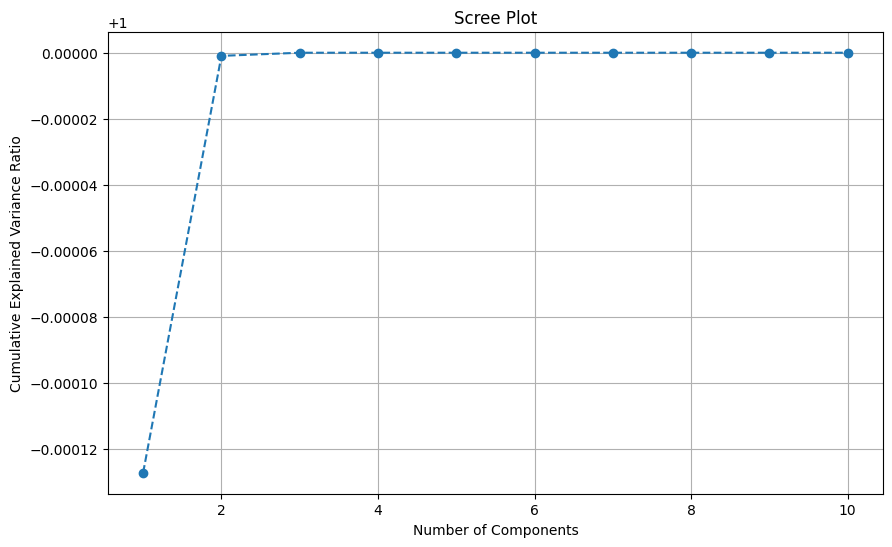

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Fit PCA
pca = PCA(n_components=10)
pca.fit(X_train_imputed)

# Step 2: Extract explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Step 3: Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.show()


In [42]:
# Use PCA with 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_imputed)
X_test_pca = pca.transform(X_test_imputed)

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Further increased values
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [5, 7, 9, 11, 13],  # Further increased values
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Further increased values
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Further increased values
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
}

In [52]:
# Step 3: Set up cross-validation and hyperparameter tuning
xgb_model = XGBRegressor(random_state=42)

# Use mean squared error as the scoring metric
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=mse_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model with hyperparameter tuning
grid_search.fit(X_train_pca, y_train)

# Best parameters found
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Use the best estimator to predict on the test set
best_model = grid_search.best_estimator_

# Save the model to a file
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01

/Users/gunther/Library/Mobile Documents/com~apple~CloudDocs/Documents/BDatSci-Year-4/Hackathon/StandardBankHackathon/notebook/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=13, n_estimators=500, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=400, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=400, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] EN

In [55]:
# Load the model from the file
with open('best_xgb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Step 4: Evaluate the model
y_pred = loaded_model.predict(X_test_pca)
# Round predictions to the nearest .25 eg. 1.25, 1.5, 1.75, 2.0
y_pred = np.round(y_pred * 4) / 4
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.4f}")
# Get the r-squared value
r2 = loaded_model.score(X_test_pca, y_test)
print(f"R-squared value on the test set: {r2:.4f}")

Mean Squared Error on the test set: 0.8711
R-squared value on the test set: 0.0924


# Random Forest Classifier


In [56]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [61]:
# Set up cross-validation and hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)

# Use mean squared error as the scoring metric
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=mse_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model with hyperparameter tuning
grid_search.fit(X_train_pca, y_train)

# Best parameters found
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Use the best estimator to predict on the test set
best_model = grid_search.best_estimator_

# Save the model to a file
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Fitting 5 folds for each of 2250 candidates, totalling 11250 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_spli

/Users/gunther/Library/Mobile Documents/com~apple~CloudDocs/Documents/BDatSci-Year-4/Hackathon/StandardBankHackathon/notebook/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.4s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=300; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=300; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=500; total time=   0.3s
[CV] END max_depth=50, max_features

/Users/gunther/Library/Mobile Documents/com~apple~CloudDocs/Documents/BDatSci-Year-4/Hackathon/StandardBankHackathon/notebook/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
3750 fits failed out of a total of 11250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1653 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gunther/Library/Mobile Documents/com~apple~CloudDocs/Documents/BDatSci-Year-4/Hackathon/StandardBankHackathon/notebook/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gunther/Library/Mobile Documents/com~apple~CloudDocs/D

In [30]:
# Load the model from the file
with open('best_rf_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Step 4: Evaluate the model
y_pred = loaded_model.predict(X_test_pca)
y_pred = np.round(y_pred * 4) / 4
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.4f}")
#Get the r-squared value
r2 = loaded_model.score(X_test_pca, y_test)
print(f"R-squared value on the test set: {r2:.4f}")

Mean Squared Error on the test set: 0.8918
R-squared value on the test set: 0.0922


# Support Vector Regression


In [43]:
from sklearn.svm import SVR

In [44]:
# Define the extended parameter grid for hyperparameter tuning
param_grid = {
    'C': [50, 100, 150, 200, 250, 300],  # Increased range of C values
    'kernel': ['rbf'],#, 'poly', 'sigmoid'],  # Added more kernel types
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Added specific gamma values
    'epsilon': [0.1, 0.2, 0.5]  # Added more epsilon values
}

In [45]:
## Don't run. It runs for a long time

# Set up cross-validation and hyperparameter tuning
svr_model = SVR()

# Use mean squared error as the scoring metric
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svr_model,
    param_grid=param_grid,
    scoring=mse_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model with hyperparameter tuning
grid_search.fit(X_train_pca, y_train)

# Best parameters found
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Use the best estimator to predict on the test set
best_model = grid_search.best_estimator_

# Save the model to a file
with open('best_svr_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END .........C=50, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=50, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=50, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=50, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=50, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=50, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=50, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..........C=50, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=50, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=50, epsilon=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........C=50, epsilon=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........C=50, epsilon=0.1, gamma=au

In [46]:
# Load the model from the file
with open('best_svr_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Step 4: Evaluate the model
y_pred = loaded_model.predict(X_test_pca)
y_pred = np.round(y_pred * 4) / 4
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.4f}")
# Get the r-squared value
r2 = loaded_model.score(X_test_pca, y_test)
print(f"R-squared value on the test set: {r2:.4f}")

Mean Squared Error on the test set: 1.1758
R-squared value on the test set: -0.1707
